In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!wget 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'

--2021-07-21 16:52:13--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz.9’

BSDS300-images.tgz. 100%[===================>]  21.18M  3.01MB/s    in 6.1s    

2021-07-21 16:52:19 (3.49 MB/s) - ‘BSDS300-images.tgz.9’ saved [22211847/22211847]



In [26]:
from os import listdir
from os.path import join

import torch.utils.data as data
from PIL import Image

import cv2
import numpy as np

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input_image = load_img(self.image_filenames[index])
        target = input_image.copy()
        if self.input_transform:
            input_image = self.input_transform(input_image)
        if self.target_transform:
            target = self.target_transform(target)

        return input_image, target

    def __len__(self):
        return len(self.image_filenames)

In [27]:
import tarfile
from os import remove
from os.path import exists, join, basename

from six.moves import urllib
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


def download_bsd300(dest="/content/dataset/"):
    output_image_dir = join(dest, "BSDS300/images")   
    print("Extracting data")
    with tarfile.open('/content/BSDS300-images.tgz') as tar:
      for item in tar:
          tar.extract(item, '/content/dataset')

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))
    
def get_new_unseen_image(upscale_factor):
    img_path = "/content/drive/MyDrive/MINI PROJECT/new"
    crop_size = calculate_valid_crop_size(256, upscale_factor)
    return DatasetFromFolder(img_path,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

In [28]:
import torch
import torch.nn as nn


class Net(torch.nn.Module):
    def __init__(self, num_channels, upscale_factor, d=64, s=12, m=4):
        super(Net, self).__init__()

        self.first_part = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=d, kernel_size=5, stride=1, padding=2),
                                        nn.PReLU())

        self.layers = []
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        for _ in range(m):
            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.PReLU())
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))

        self.mid_part = torch.nn.Sequential(*self.layers)

        # Deconvolution
        self.last_part = nn.ConvTranspose2d(in_channels=d, out_channels=num_channels, kernel_size=9, stride=upscale_factor, padding=3, output_padding=1)

    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out

    def weight_init(self, mean=0.0, std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.0001)
                if m.bias is not None:
                    m.bias.data.zero_()

In [29]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

In [30]:
from __future__ import print_function
from math import log10

import torch
import torch.backends.cudnn as cudnn

class FSRCNNTrainer(object):
    def __init__(self,  training_loader, testing_loader):
        super(FSRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = 0.00003
        self.nEpochs = 10
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = 123
        self.upscale_factor = 4
        self.training_loader = training_loader
        self.testing_loader = testing_loader

    def build_model(self):
        self.model = Net(num_channels=1, upscale_factor=self.upscale_factor).to(self.device)
        self.model.weight_init(mean=0.0, std=0.2)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)  # lr decay

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        for batch_num, (data, target) in enumerate(self.training_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(data), target)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))

    def test(self):
        self.model.eval()
        avg_psnr = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                psnr = 10 * log10(1 / mse.item())
                avg_psnr += psnr
                progress_bar(batch_num, len(self.testing_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

        print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))

    def run(self):
        self.build_model()
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            if epoch == self.nEpochs:
                self.save_model()
    
    def predict(self):
        self.model.eval()
        pred = get_new_unseen_image(4)
        pred_data_loader = DataLoader(dataset=pred , shuffle=False)

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(pred_data_loader):
                data, target = data.to(self.device), target.to(self.device)

                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                psnr = 20 * log10(1 / mse.item())
        
        print("PSNR : ",psnr)

        outputs = prediction.cpu()
        save_image(outputs, f"/content/drive/MyDrive/MINI PROJECT/new/output.png")
      
        original = cv2.imread("/content/drive/MyDrive/MINI PROJECT/new/new_flower_test.png")
        fsrcnn = cv2.imread("/content/drive/MyDrive/MINI PROJECT/new/output.png")

        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original')
        axs[1].imshow(cv2.cvtColor(fsrcnn, cv2.COLOR_BGR2RGB))
        axs[1].set_title('FSRCNN')
      

In [31]:
from __future__ import print_function
from torch.utils.data import DataLoader

# ===========================================================
# Set train dataset & test dataset
# ===========================================================
print('===> Loading datasets')
train_set = get_training_set(4)
test_set = get_test_set(4)


training_data_loader = DataLoader(dataset=train_set, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, shuffle=False)


model = FSRCNNTrainer(training_data_loader, testing_data_loader)
model.run()




===> Loading datasets
Extracting data
Extracting data

===> Epoch 1 starts:
 200/200 [================================================================================>]  Step: 29ms | Tot: 5s351ms | Loss: 0.0246
    Average Loss: 0.0246
 100/100 [================================================================================>]  Step: 21ms | Tot: 2s204ms | PSNR: 18.6675
    Average PSNR: 18.6675 dB

===> Epoch 2 starts:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 200/200 [================================================================================>]  Step: 26ms | Tot: 5s307ms | Loss: 0.0125
    Average Loss: 0.0125
 100/100 [================================================================================>]  Step: 27ms | Tot: 2s200ms | PSNR: 19.8712
    Average PSNR: 19.8712 dB

===> Epoch 3 starts:
 200/200 [================================================================================>]  Step: 27ms | Tot: 5s335ms | Loss: 0.0103
    Average Loss: 0.0103
 100/100 [================================================================================>]  Step: 24ms | Tot: 2s177ms | PSNR: 20.5047
    Average PSNR: 20.5047 dB

===> Epoch 4 starts:
 200/200 [================================================================================>]  Step: 26ms | Tot: 5s127ms | Loss: 0.0091
    Average Loss: 0.0091
 100/100 [================================================================================>]  Step: 24ms | Tot: 2s153ms | PSNR: 21.0596
    Averag

PSNR :  42.39167625134275


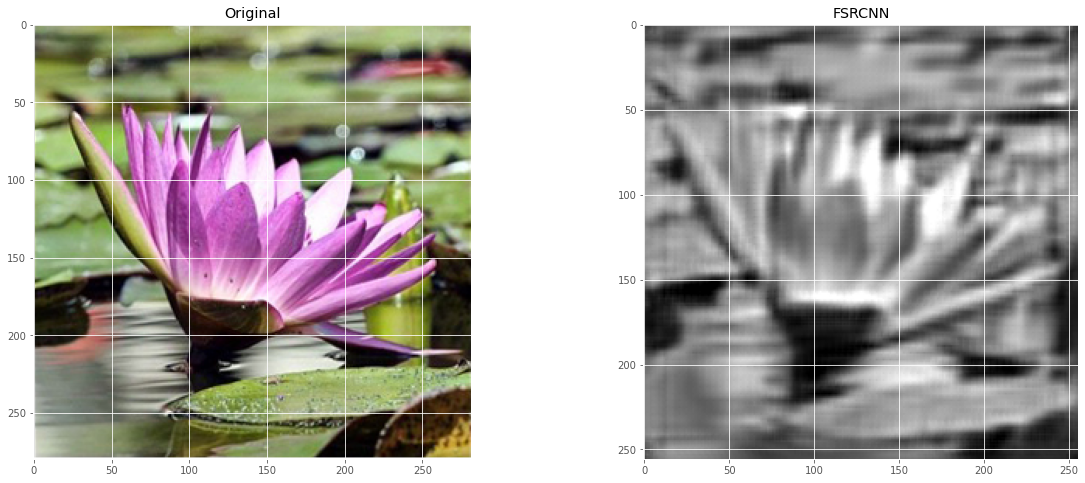

In [32]:
model.predict()